<div>
<img src="img/Princeton%20logo.png" width="150" align="right"/>
</div>

<div>
<img src="img/IRIS-HEP%20logo.png" width="120" align="left"/>
</div>

<br>
<br>
<br>
<br>

# Awkward RDataFrame Tutorial
### Ianna Osborne, Jim Pivarski 
*Princeton University*

###### [PyHEP 2022 (virtual) Workshop, 12 - 16 Sept 2022](https://indico.cern.ch/event/1150631/timetable/)

## Awkward Arrays and RDataFrame

Awkward Arrays and RDataFrame are two very different ways of performing calculations at scale.

[Awkward Array](https://github.com/scikit-hep/awkward) is a library for nested, variable-sized data, including arbitrary-length lists, records, mixed types, and missing data, using NumPy-like idioms. It is a cornerstone of user analyses in Python eco-system.

[RDataFrame](https://root.cern.ch/doc/master/classROOT_1_1RDataFrame.html) - [ROOT](https://root.cern.ch/doc/master/namespaceROOT.html)'s declarative analysis interface that supports many input formats.

The Awkward-RDF bridge provides users with more flexibility in mixing different packages and languages in their analyses. There are numerous benefits of combining both Python and C++. Physicists can mix analyses using Awkward Arrays, Numba, and ROOT C++ in memory, without saving to disk and without leaving their environment.

<div>
<img src="img/Awkward%20Array%20and%20other%20projects.png" width="800" align="center"/>
</div>

Let’s start from Awkward Arrays and put them into an RDataFrame.

## From Awkward Arrays to RDataFrame
We need to use Awkward Arrays version 2 and PyRoot.

In [1]:
import awkward._v2 as ak
import ROOT

Welcome to JupyROOT 6.26/02


In [2]:
array_x = ak.Array(
        [
            {"x": [1.1, 1.2, 1.3]},
            {"x": [2.1, 2.21]},
            {"x": [3.1]},
            {"x": [4.1, 4.2, 4.3, 4.4]},
            {"x": [5.1]},
        ]
    )
array_y = ak.Array([1, 2, 3, 4, 5])
array_z = ak.Array([1.1, 2.2, 3.3, 4.4, 5.5])

In [3]:
%%time

df = ak.to_rdataframe({"x": array_x, "y": array_y, "z": array_z})

CPU times: user 1.58 s, sys: 48.9 ms, total: 1.63 s
Wall time: 1.66 s


The awkward style `ak.to_rdataframe` function requires a dictionary: a key defines a column name of an Awkward Array that will be placed in the RDataFrame. This operation does not execute the RDF event loop. There is a small overhead of generating [Awkward RDataSource C++ code](https://github.com/scikit-hep/awkward/blob/main/src/awkward/_v2/_connect/rdataframe/to_rdataframe.py#L152-L252). This does not depend on the data size - the data are not copied.

In [4]:
# Let's check the state of the dataframe:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_IYd7H0fXJlI     Dataset
y               int64_t                         Dataset
z               double                          Dataset

The `x` column contains an Awkward Array with a made-up type; `awkward::Record_cKnX5DyNVM`.

Awkward Arrays are dynamically typed, so in a C++ context, the type name is hashed. In practice, there is no need to know the type. The C++ code should use a placeholder type specifier `auto`. The type of the variable that is being declared will be automatically deduced from its initializer.

The `awkward_index_` column is always defined; it is used internally. 

In [5]:
df.GetColumnType("x")

'awkward::Record_IYd7H0fXJlI'

In [6]:
df.GetColumnType("y")

'int64_t'

In [7]:
df.GetColumnType("z")

'double'

Now we can schedule the operations on RDF, for example, filtering. Note that this operation does not execute the event loop.

In [8]:
df = df.Filter("y > 2")

In [9]:
# Let's check that this operation does not execute the event loop.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_IYd7H0fXJlI     Dataset
y               int64_t                         Dataset
z               double                          Dataset

In [10]:
%%time


# Trigger the event loop once to retrieve all selected columns.
out = ak.from_rdataframe(
    df,
    columns=("x", "y", "z",),
)

CPU times: user 7.85 s, sys: 123 ms, total: 7.97 s
Wall time: 8 s


In [11]:
out

<Array [{y: 3, z: 3.3, x: {...}}, ..., {...}] type='3 * {y: int64, z: float...'>

In [12]:
# Let's check the type of the Awkward Array.
# The initial input Record_* is indexed because of 
# the filter selection; it's content not copied.
out.show(type=True)

type: 3 * {
    y: int64,
    z: float64,
    x: {
        x: var * float64
    }
}
[{y: 3, z: 3.3, x: {x: [3.1]}},
 {y: 4, z: 4.4, x: {x: [4.1, ..., 4.4]}},
 {y: 5, z: 5.5, x: {x: [5.1]}}]


In [13]:
# Let's check the filtered entries for "y > 2".
print(out["y"].to_list())
print(out["z"].to_list())
print(out["x"].to_list())

[3, 4, 5]
[3.3, 4.4, 5.5]
[{'x': [3.1]}, {'x': [4.1, 4.2, 4.3, 4.4]}, {'x': [5.1]}]


In [14]:
# Check to make sure we triggered the event loop only once.
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            4
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
awkward_index_  Long64_t                        Define
x               awkward::Record_IYd7H0fXJlI     Dataset
y               int64_t                         Dataset
z               double                          Dataset

## From RDataFrame to Awkward Arrays

The *`ak.from_rdataframe`* function converts selected columns to native Awkward Arrays. The function takes a tuple of strings that are the RDF column names and recognizes the following column data types:

* Primitive types: `integer`, `float`, `double`, `std::complex<double>`, etc.
* Lists of primitive types and the arbitrary depth nested lists of primitive types: `std::vector<double>`, `RVec<int>`, etc.
* Awkward types: run-time generated types derived from `awkward::ArrayView` or `awkward::RecordView`
  * because Awkward Arrays are immutable no copy required
<div>
<img src="img/Awkward%20types.png" width="500" align="left"/>
</div>

In [15]:
import awkward._v2 as ak
import ROOT

In [16]:
# Create a dataframe
df = ROOT.RDataFrame('Events', 'Run2012BC_DoubleMuParked_Muons.root')

CMS data from [CERN Open Data portal](http://opendata.web.cern.ch/record/12341).
This dataset contains about 60 mio. data events from the CMS detector taken in 2012 
during Run B and C. The original AOD dataset is converted to the NanoAOD format and 
reduced to the muon collections. The dataset in the file is called Events and contains 
columns as described in the table below.
<br>Dataset semantics
```
Variable Type	Description
nMuon	unsigned int	Number of muons in this event
Muon_pt	float[nMuon]	Transverse momentum of the muons (stored as an array of size nMuon)
Muon_eta	float[nMuon]	Pseudorapidity of the muons
Muon_phi	float[nMuon]	Azimuth of the muons
Muon_mass	float[nMuon]	Mass of the muons
Muon_charge	int[nMuon]	Charge of the muons (either 1 or -1)
```
<br>DoubleMuParked dataset from 2012 in NanoAOD format reduced on muons
<br>Wunsch, Stefan
<br>Cite as: Wunsch, Stefan; (2019). DoubleMuParked dataset from 2012 in NanoAOD format 
 reduced on muons. CERN Open Data Portal. DOI:10.7483/OPENDATA.CMS.LVG5.QT81
<br>Dataset Derived CMS CERN-LHC

In [17]:
# Describe the state of the dataframe.
# Note that this operation is not running the event loop.
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            6
Columns from defines        0
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [18]:
# Build a small analysis studying the invariant mass of dimuon systems.
df = df.Filter('nMuon == 2')\
       .Filter('Muon_charge[0] != Muon_charge[1]')\
       .Define('Dimuon_mass', 'InvariantMass(Muon_pt, Muon_eta, Muon_phi, Muon_mass)')\
       .Filter('Dimuon_mass > 70')\
       .Range(1000)

See [ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) for more information.

In [19]:
# Trigger the event loop 
# by asking for the mean of the dimuon mass.
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



In [20]:
# Check that this operation triggered the event loop once:
#
# Event loops run             1
#
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             1
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

Let's take the data out as Awkward Arrays. Here we copy the contents of the `RVecs` to the Numpy buffers.

In [21]:
%%time

# Convert selected columns to Awkward array.
array = ak.from_rdataframe(
        df,                #     Type                            Origin
        columns=(          #     ----                            ------
            "Dimuon_mass", #     float                           Define
            "Muon_charge", #     ROOT::VecOps::RVec<Int_t>       Dataset
            "Muon_eta",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_mass",   #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_phi",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_pt",     #     ROOT::VecOps::RVec<Float_t>     Dataset
            "nMuon",       #     UInt_t                          Dataset
        ),
    )

CPU times: user 9.92 s, sys: 131 ms, total: 10.1 s
Wall time: 10.1 s


In [22]:
array

<Array [{Dimuon_mass: 114, ...}, ..., {...}] type='1000 * {Dimuon_mass: flo...'>

In [23]:
# Check the array type.
array.show(type=True)

type: 1000 * {
    Dimuon_mass: float32,
    Muon_charge: var * int32,
    Muon_eta: var * float32,
    Muon_mass: var * float32,
    Muon_phi: var * float32,
    Muon_pt: var * float32,
    nMuon: uint32
}
[{Dimuon_mass: 114, Muon_charge: [-1, 1], Muon_eta: [...], Muon_mass: ..., ...},
 {Dimuon_mass: 88.3, Muon_charge: [1, -1], Muon_eta: [2.2, ...], ...},
 {Dimuon_mass: 88.3, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 91.3, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 93.6, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 90.9, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 89.2, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 82.3, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 94.6, Muon_charge: [1, -1], Muon_eta: [...], ...},
 {Dimuon_mass: 89.2, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 ...,
 {Dimuon_mass: 86.4, Muon_charge: [-1, 1], Muon_eta: [...], ...},
 {Dimuon_mass: 77.1, Muon_charge: [-1, 1]

In [24]:
# Check that all the columns were retrieved in a single event loop:
#
# Event loops run             2
#
df.Describe().Print()

Dataframe from TChain Events in file Run2012BC_DoubleMuParked_Muons.root

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             2
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Muon_charge     ROOT::VecOps::RVec<Int_t>       Dataset
Muon_eta        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_mass       ROOT::VecOps::RVec<Float_t>     Dataset
Muon_phi        ROOT::VecOps::RVec<Float_t>     Dataset
Muon_pt         ROOT::VecOps::RVec<Float_t>     Dataset
nMuon           UInt_t                          Dataset

In [25]:
array["Dimuon_mass"]

<Array [114, 88.3, 88.3, 91.3, ..., 89.6, 91.1, 90.1] type='1000 * float32'>

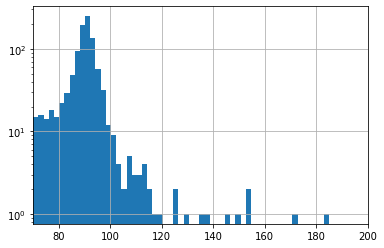

In [26]:
import matplotlib
import matplotlib.pyplot as plt

# plot `Dimuon_mass`
plt.hist(array["Dimuon_mass"], bins=200)
plt.xlim(70, 200)
plt.yscale('log')
plt.grid(True)

In [27]:
import numpy as np

In [28]:
np.mean(array["Dimuon_mass"])

91.438576

## Large-scale Awkward data roundtrip

Note, if we want to process all events (not a 1000) the multi-threading can be enabled with:
```python
# Enable multi-threading
ROOT.ROOT.EnableImplicitMT()
```

In [29]:
# Create a dataframe
df = ROOT.RDataFrame('Events', 'Run2012BC_DoubleMuParked_Muons.root')

Let's take out all 60 mio. data events as an Awkward Array:

In [30]:
%%time

array = ak.from_rdataframe(
        df,                #     Type                            Origin
        columns=(          #     ----                            ------
            "Muon_charge", #     ROOT::VecOps::RVec<Int_t>       Dataset
            "Muon_eta",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_mass",   #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_phi",    #     ROOT::VecOps::RVec<Float_t>     Dataset
            "Muon_pt",     #     ROOT::VecOps::RVec<Float_t>     Dataset
            "nMuon",       #     UInt_t                          Dataset
        ),
    )

CPU times: user 2min 21s, sys: 1min 9s, total: 3min 31s
Wall time: 3min 52s


In [31]:
array

<Array [{Muon_charge: [...], ...}, ..., {...}] type='61540413 * {Muon_charg...'>

In [32]:
array.show(type=True)

type: 61540413 * {
    Muon_charge: var * int32,
    Muon_eta: var * float32,
    Muon_mass: var * float32,
    Muon_phi: var * float32,
    Muon_pt: var * float32,
    nMuon: uint32
}
[{Muon_charge: [-1, -1], Muon_eta: [1.07, -0.564], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.428, 0.349], Muon_mass: [...], ...},
 {Muon_charge: [1], Muon_eta: [2.21], Muon_mass: [0.106], Muon_phi: ..., ...},
 {Muon_charge: [1, 1, 1, 1], Muon_eta: [-1.59, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, -1, 1, 1], Muon_eta: [-2.17, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1, -1], Muon_eta: [-1.37, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [-0.532, -1], Muon_mass: [...], ...},
 {Muon_charge: [1, -1], Muon_eta: [-0.772, ...], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [0.442, 0.702], Muon_mass: [...], ...},
 {Muon_charge: [-1, 1], Muon_eta: [2.34, 2.35], Muon_mass: [...], ...},
 ...,
 {Muon_charge: [1, -1], Muon_eta: [0.252, 0.275], Muon_ma

Let's put the whole array in another RDataFrame as a single column:

In [33]:
%%time

df1 = ak.to_rdataframe({"Events": array})

CPU times: user 729 ms, sys: 274 ms, total: 1 s
Wall time: 1.17 s


In [34]:
df1.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            2
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Events          awkward::Record_eC7565dng       Dataset
awkward_index_  Long64_t                        Define

In this case, the access to the array records is as follows: `Events.nMuon()`, `Events.Muon_pt()`, `Events.Muon_eta()`, `Events.Muon_phi()`, `Events.Muon_mass()`. An `integer` index can be used to access the elements of the record: `Events.Muon_charge()[0]`. An `InvariantMass` C++ function can be applied to define a new `Dimuon_mass` column:

In [35]:
df2 = df1.Filter('Events.nMuon() == 2')\
         .Filter('Events.Muon_charge()[0] != Events.Muon_charge()[1]')\
         .Define('Dimuon_mass', 'InvariantMass(Events.Muon_pt(), Events.Muon_eta(), Events.Muon_phi(), Events.Muon_mass())')\
         .Filter('Dimuon_mass > 70')\
         .Range(1000)

In [36]:
df2.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            3
Columns from defines        2
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
Dimuon_mass     float                           Define
Events          awkward::Record_eC7565dng       Dataset
awkward_index_  Long64_t                        Define

In [37]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df2.Mean('Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



Let's put the array records as `RVec`s in an RDataFrame (see cell 3 for time comparison):

In [38]:
%%time

df = ak.to_rdataframe({"ak_Muon_charge": array["Muon_charge"], 
                       "ak_Muon_eta": array["Muon_eta"], 
                       "ak_Muon_mass": array["Muon_mass"],
                       "ak_Muon_phi": array["Muon_phi"],
                       "ak_Muon_pt": array["Muon_pt"],
                       "ak_nMuon": array["nMuon"],
                      })

CPU times: user 1.3 s, sys: 93.9 ms, total: 1.39 s
Wall time: 1.42 s


In [39]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            7
Columns from defines        1
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
ak_Muon_charge  ROOT::VecOps::RVec<int32_t>     Dataset
ak_Muon_eta     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_mass    ROOT::VecOps::RVec<float>       Dataset
ak_Muon_phi     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_pt      ROOT::VecOps::RVec<float>       Dataset
ak_nMuon        uint32_t                        Dataset
awkward_index_  Long64_t                        Define

Let's define our own `invariant_mass` function (ok, it's a copy of [InvariantMass](https://root.cern.ch/doc/master/RVec_8hxx_source.html#l02923)):

In [40]:
compiler = ROOT.gInterpreter.Declare

In [41]:
done = compiler("""
template <typename T>
T invariant_mass(const ROOT::VecOps::RVec<T>& pt, 
                 const ROOT::VecOps::RVec<T>& eta, 
                 const ROOT::VecOps::RVec<T>& phi, 
                 const ROOT::VecOps::RVec<T>& mass)
{
  const std::size_t size = pt.size();
 
  R__ASSERT(eta.size() == size && phi.size() == size && mass.size() == size);

  T x_sum = 0.;
  T y_sum = 0.;
  T z_sum = 0.;
  T e_sum = 0.;

   for (std::size_t i = 0u; i < size; ++ i) {
     // Convert to (e, x, y, z) coordinate system and update sums
     const auto x = pt[i] * std::cos(phi[i]);
     x_sum += x;
     const auto y = pt[i] * std::sin(phi[i]);
     y_sum += y;
     const auto z = pt[i] * std::sinh(eta[i]);
     z_sum += z;
     const auto e = std::sqrt(x * x + y * y + z * z + mass[i] * mass[i]);
     e_sum += e;
  }

  // Return invariant mass with (+, -, -, -) metric
  return std::sqrt(e_sum * e_sum - x_sum * x_sum - y_sum * y_sum - z_sum * z_sum);
}
""")
assert done is True

In [42]:
df = df.Filter('ak_nMuon == 2')\
       .Filter('ak_Muon_charge[0] != ak_Muon_charge[1]')\
       .Define('ak_Dimuon_mass', 'invariant_mass(ak_Muon_pt, ak_Muon_eta, ak_Muon_phi, ak_Muon_mass)')\
       .Filter('ak_Dimuon_mass > 70')\
       .Range(1000)

In [43]:
df.Describe().Print()

Dataframe from datasource Custom Datasource

Property                Value
--------                -----
Columns in total            8
Columns from defines        2
Event loops run             0
Processing slots            1

Column          Type                            Origin
------          ----                            ------
ak_Dimuon_mass  float                           Define
ak_Muon_charge  ROOT::VecOps::RVec<int32_t>     Dataset
ak_Muon_eta     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_mass    ROOT::VecOps::RVec<float>       Dataset
ak_Muon_phi     ROOT::VecOps::RVec<float>       Dataset
ak_Muon_pt      ROOT::VecOps::RVec<float>       Dataset
ak_nMuon        uint32_t                        Dataset
awkward_index_  Long64_t                        Define

In [44]:
print('\nApproximate mass of the Z boson: {:.2f} GeV\n'.format(
        df.Mean('ak_Dimuon_mass').GetValue()))


Approximate mass of the Z boson: 91.44 GeV



Awkward Arrays and RDataFrame provide two very different ways of performing large scale.
By adding the ability to convert between them, users get the best of both.
The Awkward-RDF bridge provides users with more flexibility in mixing different packages and languages in their analyses.
It is a part of Awkward version 2, which is currently a submodule `ak._v2`.
Awkward version 2 will be fully released at the beginning of December 2022. You can see the time line [here](https://github.com/scikit-hep/awkward/wiki).

<div>
<img src="img/NSF%20logo.png" width="80" align="left"/>
</div>

#### OAC-1836650